# M2.3 Support Vector Machine Classifier 

## libraries

In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os 
import sys
import joblib

# import custom functions 
sys.path.append(os.path.relpath('../shared_functions/'))
import bwi_dataset_training_funtions as sf 

## initalize subdirs 

In [2]:
sf.create_directory_structure()

Directory already exists: ./metrics
Directory already exists: ./model
Directory already exists: ./cross_validation


## load datasets

In [247]:
# read in datasets
data_test = pd.read_csv('../../../datasets/ml_bwi_v3_test.csv')
data_train = pd.read_csv('../../../datasets/ml_bwi_v3_train_imputed.csv', index_col=0)

## split datasets into features, targets and grouping subsets

In [248]:
# split into feautres, targets and groupsc
groups_test, features_test, targets_test = sf.split_input_data(data_test)
groups_train, features_train, targets_train = sf.split_input_data(data_train)

## set up preprocessing for all experiments 

In [249]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [250]:
# set selectors
cat_selector = selector(dtype_include=object)
num_selector = selector(dtype_include=np.number)

# set transformers 
# OHE with handle_unknown='ignore' to ignore unseen categories if appearing
# in the test set (due to the train-test split and imputation)
cat_transformer = OneHotEncoder(handle_unknown='ignore') 
num_transformer = StandardScaler()

# create ColumnTransformer 
preprocessor = ColumnTransformer(
    [
        ('num', num_transformer, num_selector),
        ('cat', cat_transformer, cat_selector)
    ]
)

## Algorithm/Implementation selection

We select the C-Support Vector Classification implementation since this allows us to test multiple Kernels. Other implementations might have lower computation times. 

## SVC with default hyperparameters - (full) imputed dataset with class weights
We use cross_val_predict here to being able to get a classification report and a correlation matrix which allows us to have a closer look at the effects of class imbalance in the dataset. 

**In the following, the default parameters AND a balanced class weight (inversly to the class ratios) is used** 

In [257]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedGroupKFold

In [8]:
# HistGradientBoostingClassifier
# we set class weighting inversly to the label distribution
svc = SVC(class_weight='balanced',
          cache_size=500,
          random_state=42)

# create pipeline 
svc_pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('classifier', svc)
    ]
)

In [ ]:
# set StratifiedGroupKfold as cv-strategy 
cv = StratifiedGroupKFold(n_splits=5) 

default_svc_predictions = cross_val_predict(svc_pipe,
                                             features_train,
                                             targets_train,
                                             groups=groups_train['Tnr'],
                                             cv=cv,
                                             n_jobs=-1) # all 


              precision    recall  f1-score   support

       Beech       0.91      0.85      0.88     22141
       Birch       0.71      0.88      0.78      3771
 Douglas fir       0.35      0.70      0.47      2441
         Fir       0.35      0.77      0.48      2818
       Larch       0.44      0.73      0.55      2942
      Maples       0.24      0.47      0.32      1938
        Oaks       0.87      0.82      0.84     11752
        Pine       0.93      0.86      0.90     36580
      Spruce       0.94      0.84      0.89     53502

    accuracy                           0.84    137885
   macro avg       0.64      0.77      0.68    137885
weighted avg       0.88      0.84      0.85    137885



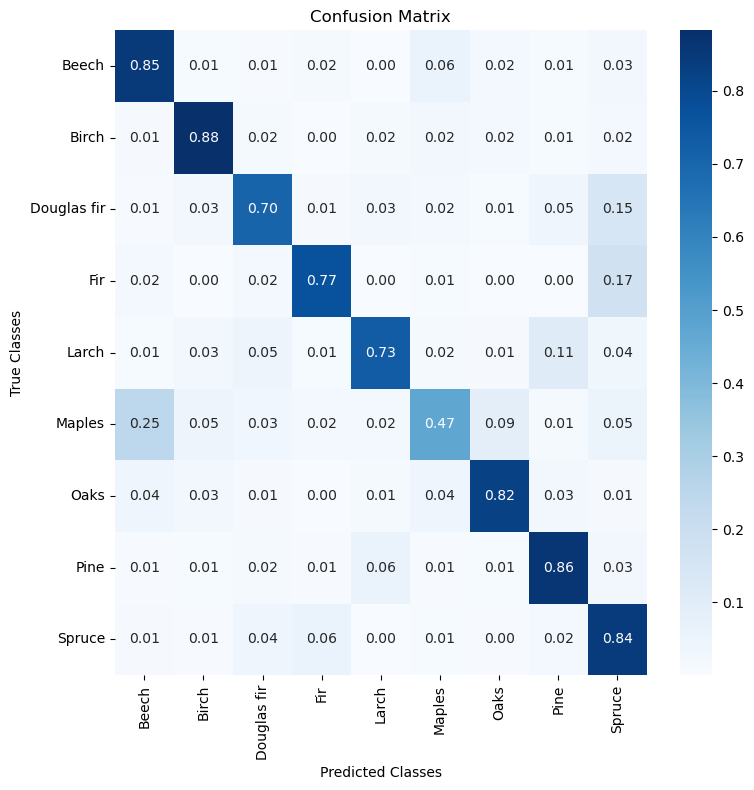

In [11]:
sf.compute_and_return_metrics(targets_train,
                              default_svc_predictions,
                              'default_svc_cv')

## SVC with default parameters - undersampled dataset without class weights 

**In the following an undersampled subset of the (full) imputed trainingset is used to tackle the class imbalance. Since classes are equally distributed after the majority class undersampling, we do not need to set a class weight in the algorithm.**

In [259]:
u_features_train, u_targets_train, u_groups_train = sf.random_undersample(features_train, targets_train, groups_train)

In [13]:
print(
    f"The undersampled trainingset contains {len(u_targets_train)} samples."
    f"\nThe classes are distributed as follows:\n{u_targets_train.value_counts().to_list()}"
    f"\nThe undersampled trainingset contains {len(u_targets_train)/len(targets_train)*100:.2f}% of the original samples."
)

The undersampled trainingset contains 17442 samples.
The classes are distributed as follows:
[1938, 1938, 1938, 1938, 1938, 1938, 1938, 1938, 1938]
The undersampled trainingset contains 12.65% of the original samples.


In [16]:
# HistGradientBoostingClassifier
# we set class weighting inversly to the label distribution
svc_u = SVC(random_state=42,
          cache_size=2000)

# create pipeline 
svc_pipe_u = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('classifier', svc_u)
    ]
)

In [17]:
default_svc_predictions_u = cross_val_predict(svc_pipe_u,
                                             u_features_train,
                                             u_targets_train,
                                             groups=u_groups_train['Tnr'],
                                             cv=cv)

              precision    recall  f1-score   support

       Beech       0.72      0.66      0.69      1938
       Birch       0.74      0.80      0.77      1938
 Douglas fir       0.69      0.68      0.69      1938
         Fir       0.72      0.82      0.77      1938
       Larch       0.65      0.60      0.62      1938
      Maples       0.55      0.45      0.50      1938
        Oaks       0.73      0.67      0.70      1938
        Pine       0.70      0.76      0.73      1938
      Spruce       0.58      0.65      0.61      1938

    accuracy                           0.68     17442
   macro avg       0.67      0.68      0.67     17442
weighted avg       0.67      0.68      0.67     17442



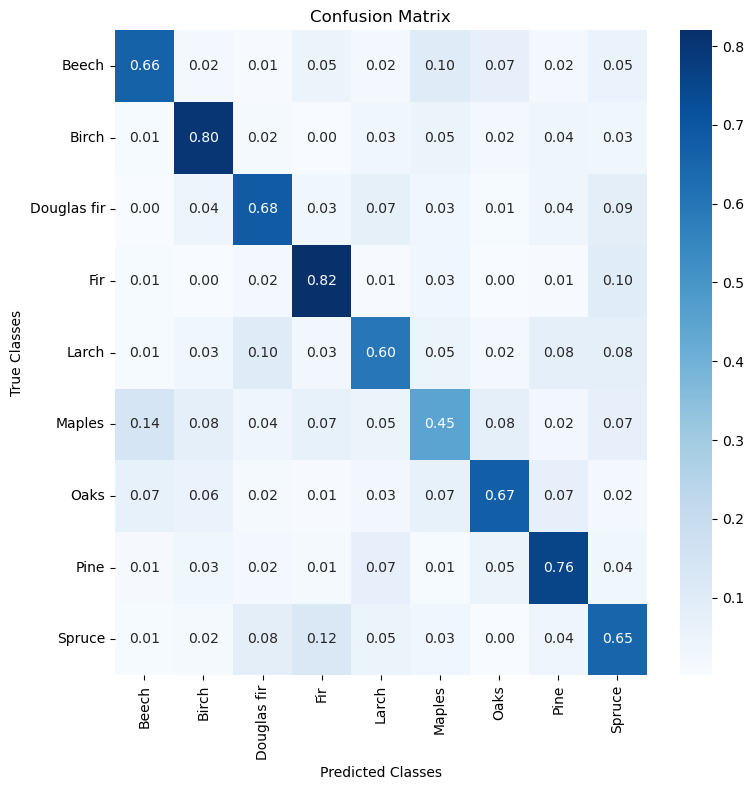

In [18]:
sf.compute_and_return_metrics(u_targets_train,
                              default_svc_predictions_u,
                              'default_svc_cv_u')

## GridSearch for SVC - undersampled dataset RBF-Kernel

We decide to use the undersampled dataset here eve though the cross-val metrics using default hyperparameters are not as good as for the (full) imputed trainingset. However, the fitting time is significantly reduced, which allows us to do a GridSearch instead of a Randomized search giving us a more accurate display of how the hyperparameters interact. 

In [255]:
from sklearn.model_selection import GridSearchCV

In [37]:
# set hyperparameter distribution 
# leading to 10*10 = 100 fits
param_grid = {
    'classifier__C': np.arange(1, 101, 10), 
    'classifier__gamma': ['auto', 'scale'] + [0.01, 0.1, 1, 10, 100], 
}

gsearch_svc_u = GridSearchCV(svc_pipe_u,
                             param_grid=param_grid,
                            cv=cv,
                            scoring=['balanced_accuracy',
                                     'f1_macro',
                                     'f1_weighted', 
                                     'recall_weighted',
                                     'precision_macro',
                                     'precision_weighted'],
                                refit='f1_macro',
                                n_jobs=-1, # all
)

In [38]:
gsearch_svc_u.fit(u_features_train, u_targets_train, groups=u_groups_train['Tnr'])


c:\Users\davha\anaconda3\envs\machine_learning_preprocessing\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=StratifiedGroupKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001D746DA1820>),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.ma...tor object at 0x000001D74132D4F0>)])),
                                       ('classifier',
                                        SVC(cache_size=2000,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91]),
                         'classifier__gamma': ['auto', 'scale', 0.01, 0.1, 1,
                                               10, 100]},
             refit='f1_macro',
             scoring=['balanced_accuracy', 'f1_macro', 'f1_weighted',
                      'recall_weighted', 'precision_macro',
                      'precision_weighted'])

In [82]:
import joblib 
joblib.dump(gsearch_svc_u, './model/gsearch_svc_u_rbf.joblib')

['./model/gsearch_svc_u_rbf.joblib']

In [42]:
gsearch_svc_u.best_params_

{'classifier__C': np.int64(91), 'classifier__gamma': 'auto'}

In [ ]:
gsearch_svc_u_cv = pd.DataFrame(gsearch_svc_u.cv_results_)
gsearch_svc_u_cv.to_csv('./cross_validation/gsearch_svc_rbf_u_cv.csv')

In [50]:
gsearch_svc_u_cv.sort_values(by='mean_test_f1_macro', ascending=False)\
    .filter(regex='param*|mean_test*|rank*').head(5)

,param_classifier__C,param_classifier__gamma,params,mean_test_balanced_accuracy,rank_test_balanced_accuracy,mean_test_f1_macro,rank_test_f1_macro,mean_test_f1_weighted,rank_test_f1_weighted,mean_test_recall_weighted,rank_test_recall_weighted,mean_test_precision_macro,rank_test_precision_macro,mean_test_precision_weighted,rank_test_precision_weighted
63,91,auto,"{'classifier__C': 91, 'classifier__gamma': 'au...",0.804857,1,0.803752,1,0.803746,1,0.804840,1,0.805513,1,0.805519,1
56,81,auto,"{'classifier__C': 81, 'classifier__gamma': 'au...",0.803652,2,0.802603,2,0.802598,2,0.803636,2,0.804193,2,0.804199,2
49,71,auto,"{'classifier__C': 71, 'classifier__gamma': 'au...",0.801930,3,0.800872,3,0.800868,3,0.801916,3,0.802434,3,0.802440,3
42,61,auto,"{'classifier__C': 61, 'classifier__gamma': 'au...",0.800555,4,0.799482,4,0.799477,4,0.800540,4,0.800958,4,0.800962,4
65,91,0.01,"{'classifier__C': 91, 'classifier__gamma': 0.01}",0.799410,5,0.798261,5,0.798256,5,0.799393,5,0.800149,5,0.800156,5


In [45]:
gsearch_svc_u_predictions = cross_val_predict(gsearch_svc_u.best_estimator_,
                                             u_features_train,
                                             u_targets_train,
                                             groups=u_groups_train['Tnr'],
                                             cv=cv)

              precision    recall  f1-score   support

       Beech       0.78      0.84      0.81      1938
       Birch       0.86      0.90      0.88      1938
 Douglas fir       0.78      0.76      0.77      1938
         Fir       0.84      0.82      0.83      1938
       Larch       0.84      0.80      0.82      1938
      Maples       0.75      0.64      0.69      1938
        Oaks       0.84      0.83      0.84      1938
        Pine       0.82      0.85      0.84      1938
      Spruce       0.73      0.81      0.77      1938

    accuracy                           0.80     17442
   macro avg       0.80      0.80      0.80     17442
weighted avg       0.80      0.80      0.80     17442



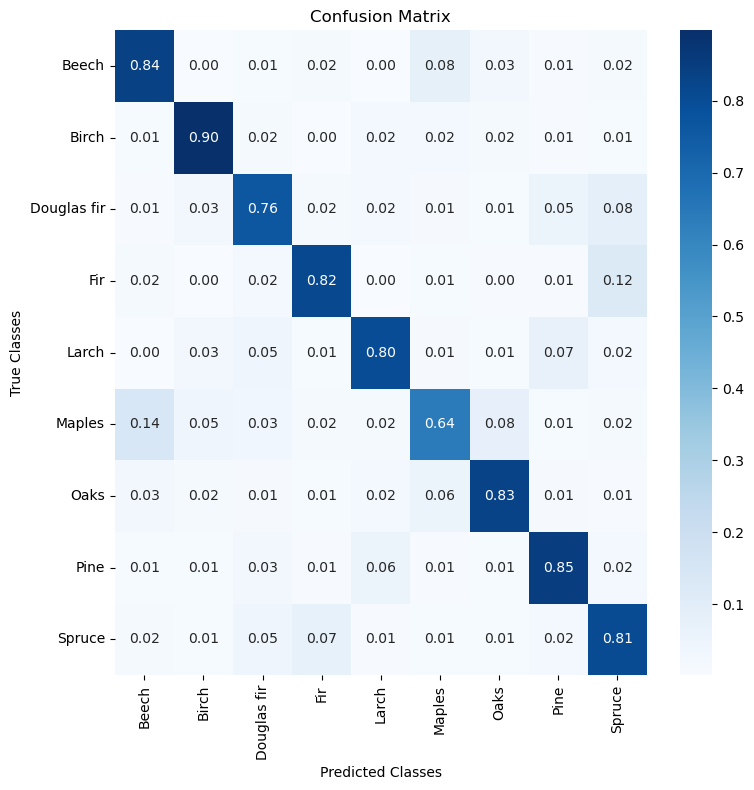

In [77]:
sf.compute_and_return_metrics(u_targets_train,
                              gsearch_svc_u_predictions,
                              'gsearch_svc_u_rbf_cv')

## GridSearch for SVC - undersampled dataset with linear Kernel 

In [261]:
cv = StratifiedGroupKFold(n_splits=5) 

In [262]:
# set hyperparameter distribution 
# leading to 10*10 = 100 fits

svc_u_linear = SVC(kernel='linear',
                   random_state=42,
                   cache_size=2000)

svc_pipe_u_linear = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('classifier', svc_u_linear)
    ]
)

param_grid = {
    'classifier__C': [1, *np.arange(10, 150, 10)]  
}

gsearch_svc_u_linear = GridSearchCV(svc_pipe_u_linear,
                            param_grid=param_grid,
                            cv=cv,
                            scoring=['balanced_accuracy',
                                    'f1_macro',
                                    'f1_weighted', 
                                    'recall_weighted',
                                    'precision_macro',
                                    'precision_weighted'],
                            refit='f1_macro',
                            n_jobs=-1, # all
)

In [263]:
gsearch_svc_u_linear.fit(u_features_train, u_targets_train, groups=u_groups_train['Tnr'])


c:\Users\davha\anaconda3\envs\machine_learning_preprocessing\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=StratifiedGroupKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000286E6D917C0>),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.ma...
             n_jobs=-1,
             param_grid={'classifier__C': [1, np.int64(10), np.int64(20),
                                           np.int64(30), np.int64(40),
                                           np.int64(50), np.int64(60),
                                           np.int64(70), np.int64(80),
                                           np.int64(90), np.int64(100),
                                           np.int64(110), np.int64(120),
                                           np.int64(130), np.int64(140)]},
             refit='f1_macro',
             scoring=['balanced_accuracy', 'f1_macro', 'f1_weighted',
                      'recall_weighted', 'precision_macro',
                      'precision_weighted'])

In [264]:
import joblib 
joblib.dump(gsearch_svc_u_linear, './model/gsearch_svc_u_linear.joblib')

['./model/gsearch_svc_u_linear.joblib']

In [265]:
gsearch_svc_u_linear.best_params_

{'classifier__C': np.int64(130)}

In [266]:
gsearch_svc_u_linear_cv = pd.DataFrame(gsearch_svc_u_linear.cv_results_)
gsearch_svc_u_linear_cv.to_csv('./cross_validation/gsearch_svc_u_linear_cv.csv')

In [289]:
gsearch_svc_u_linear_cv.sort_values(by='mean_test_f1_macro', ascending=False)\
    .head(10)\
    .filter(regex='mean_fit*|mean_test_f1_macro|param_|f1_macro_rank*')

,mean_fit_time,param_classifier__C,mean_test_f1_macro
13,513.319107,130,0.908681
14,475.672709,140,0.908339
11,528.385329,110,0.907589
12,535.599485,120,0.907521
10,456.761352,100,0.907317
8,374.097779,80,0.906556
9,421.859548,90,0.906388
6,252.502608,60,0.906357
7,309.666129,70,0.905663
5,212.200786,50,0.904478


In [279]:
gsearch_svc_u_linear_cv.sort_values(by='mean_test_f1_macro', ascending=False).to_clipboard()

In [268]:
gsearch_svc_u_linear_predictions = cross_val_predict(gsearch_svc_u_linear.best_estimator_,
                                             u_features_train,
                                             u_targets_train,
                                             groups=u_groups_train['Tnr'],
                                             cv=cv)

              precision    recall  f1-score   support

       Beech       0.94      0.94      0.94      1938
       Birch       0.91      0.96      0.94      1938
 Douglas fir       0.86      0.89      0.88      1938
         Fir       0.87      0.88      0.87      1938
       Larch       0.93      0.92      0.92      1938
      Maples       0.93      0.89      0.91      1938
        Oaks       0.95      0.94      0.94      1938
        Pine       0.91      0.88      0.89      1938
      Spruce       0.88      0.88      0.88      1938

    accuracy                           0.91     17442
   macro avg       0.91      0.91      0.91     17442
weighted avg       0.91      0.91      0.91     17442



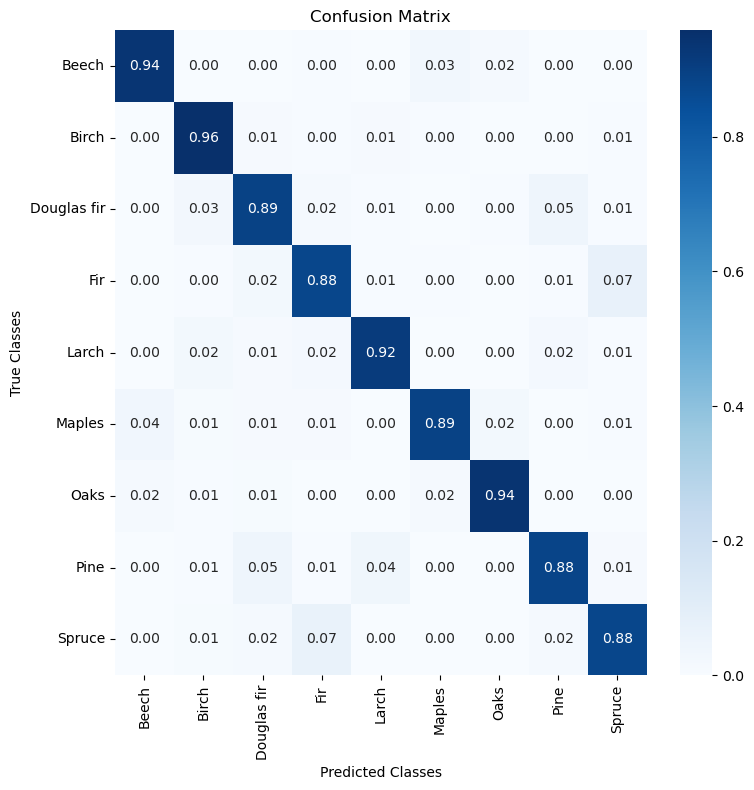

In [269]:
sf.compute_and_return_metrics(u_targets_train,
                              gsearch_svc_u_linear_predictions,
                              'gsearch_svc_u_linear_cv')

## GridSearch for SVC - undersampled dataset with polynomial kernel 

In [66]:
# set hyperparameter distribution 
# leading to 10*10 = 100 fits

svc_u_poly = SVC(kernel='poly',
                   random_state=42,
                   cache_size=2000)

svc_pipe_u_poly = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('classifier', svc_u_poly)
    ]
)

param_grid = {
    'classifier__C': np.arange(1, 101, 10), 
    'classifier__gamma': ['auto', 'scale'] + [0.01, 0.1, 1, 10, 100], 
    'classifier__degree': [2, 3, 4, 5],
}

gsearch_svc_u_poly = GridSearchCV(svc_pipe_u_poly,
                            param_grid=param_grid,
                            cv=cv,
                            scoring=['balanced_accuracy',
                                    'f1_macro',
                                    'f1_weighted', 
                                    'recall_weighted',
                                    'precision_macro',
                                    'precision_weighted'],
                            refit='f1_macro',
                            n_jobs=-1, # all
)

In [67]:
gsearch_svc_u_poly.fit(u_features_train, u_targets_train, groups=u_groups_train['Tnr'])


c:\Users\davha\anaconda3\envs\machine_learning_preprocessing\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=StratifiedGroupKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001D746DA1820>),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.ma...
                                       ('classifier',
                                        SVC(cache_size=2000, kernel='poly',
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91]),
                         'classifier__degree': [2, 3, 4, 5],
                         'classifier__gamma': ['auto', 'scale', 0.01, 0.1, 1,
                                               10, 100]},
             refit='f1_macro',
             scoring=['balanced_accuracy', 'f1_macro', 'f1_weighted',
                      'recall_weighted', 'precision_macro',
                      'precision_weighted'])

In [68]:
import joblib 
joblib.dump(gsearch_svc_u_poly, './model/gsearch_svc_u_poly.joblib')

['./model/gsearch_svc_u_poly.joblib']

In [69]:
gsearch_svc_u_poly.best_params_

{'classifier__C': np.int64(1),
 'classifier__degree': 2,
 'classifier__gamma': 100}

In [70]:
gsearch_svc_u_poly_cv = pd.DataFrame(gsearch_svc_u_poly.cv_results_)
gsearch_svc_u_poly_cv.to_csv('./cross_validation/gsearch_svc_u_poly_cv.csv')

In [79]:
gsearch_svc_u_poly_cv.sort_values(by='mean_test_f1_macro', ascending=False)\
    .filter(regex='param*|mean_test*|rank*')

,param_classifier__C,param_classifier__degree,param_classifier__gamma,params,mean_test_balanced_accuracy,rank_test_balanced_accuracy,mean_test_f1_macro,rank_test_f1_macro,mean_test_f1_weighted,rank_test_f1_weighted,mean_test_recall_weighted,rank_test_recall_weighted,mean_test_precision_macro,rank_test_precision_macro,mean_test_precision_weighted,rank_test_precision_weighted
230,81,2,100,"{'classifier__C': 81, 'classifier__degree': 2,...",0.747691,1,0.746030,1,0.746025,1,0.747678,1,0.748153,1,0.748156,1
174,61,2,100,"{'classifier__C': 61, 'classifier__degree': 2,...",0.747691,1,0.746030,1,0.746025,1,0.747678,1,0.748153,1,0.748156,1
202,71,2,100,"{'classifier__C': 71, 'classifier__degree': 2,...",0.747691,1,0.746030,1,0.746025,1,0.747678,1,0.748153,1,0.748156,1
6,1,2,100,"{'classifier__C': 1, 'classifier__degree': 2, ...",0.747691,1,0.746030,1,0.746025,1,0.747678,1,0.748153,1,0.748156,1
258,91,2,100,"{'classifier__C': 91, 'classifier__degree': 2,...",0.747691,1,0.746030,1,0.746025,1,0.747678,1,0.748153,1,0.748156,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49,11,5,auto,"{'classifier__C': 11, 'classifier__degree': 5,...",0.346398,276,0.358147,276,0.358153,276,0.346405,276,0.517731,274,0.517735,274
16,1,4,0.01,"{'classifier__C': 1, 'classifier__degree': 4, ...",0.312743,277,0.316316,277,0.316320,277,0.312750,277,0.499855,277,0.499853,277
14,1,4,auto,"{'classifier__C': 1, 'classifier__degree': 4, ...",0.286432,278,0.283259,278,0.283260,278,0.286435,278,0.492997,280,0.492992,280
23,1,5,0.01,"{'classifier__C': 1, 'classifier__degree': 5, ...",0.246128,279,0.230870,279,0.230870,279,0.246130,279,0.498528,279,0.498525,279


In [80]:
gsearch_svc_u_poly_predictions = cross_val_predict(gsearch_svc_u_poly.best_estimator_,
                                             u_features_train,
                                             u_targets_train,
                                             groups=u_groups_train['Tnr'],
                                             cv=cv)

              precision    recall  f1-score   support

       Beech       0.68      0.81      0.74      1938
       Birch       0.84      0.88      0.86      1938
 Douglas fir       0.74      0.71      0.73      1938
         Fir       0.80      0.76      0.78      1938
       Larch       0.74      0.74      0.74      1938
      Maples       0.66      0.54      0.60      1938
        Oaks       0.80      0.76      0.78      1938
        Pine       0.78      0.80      0.79      1938
      Spruce       0.69      0.73      0.71      1938

    accuracy                           0.75     17442
   macro avg       0.75      0.75      0.75     17442
weighted avg       0.75      0.75      0.75     17442



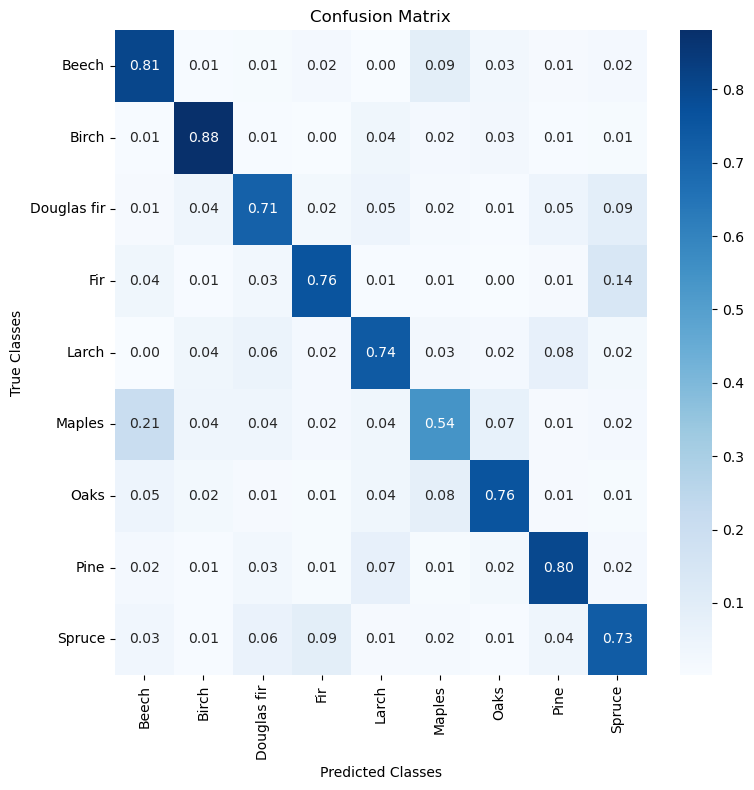

In [81]:
sf.compute_and_return_metrics(u_targets_train,
                              gsearch_svc_u_poly_predictions,
                              'gsearch_svc_u_poly_cv')

## Final evaluation with the holdout testset 

In [270]:
preds_test = gsearch_svc_u_linear.predict(features_test)

              precision    recall  f1-score   support

       Beech       0.99      0.98      0.99      3397
       Birch       0.95      0.95      0.95       281
 Douglas fir       0.62      0.95      0.75       358
         Fir       0.40      0.93      0.56       489
       Larch       0.65      0.94      0.77       392
      Maples       0.79      0.96      0.86       243
        Oaks       0.96      0.97      0.96      1323
        Pine       0.95      0.86      0.91      2848
      Spruce       0.99      0.89      0.94      7433

    accuracy                           0.92     16764
   macro avg       0.81      0.94      0.85     16764
weighted avg       0.95      0.92      0.92     16764



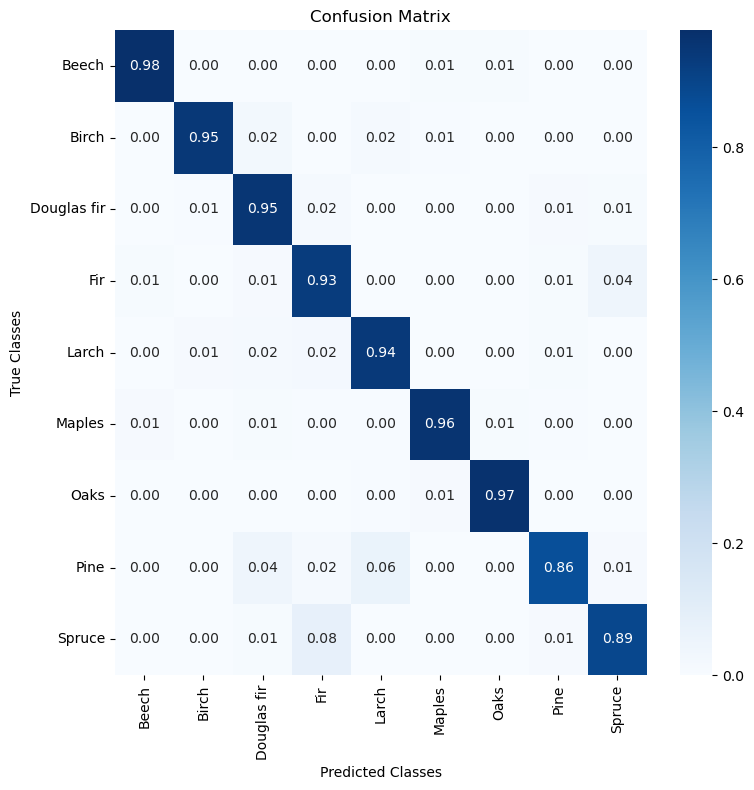

In [272]:
sf.compute_and_return_metrics(targets_test,
                              preds_test,
                              file_name='gsearch_svc_u_linear_final_test')

## Check feature importance 

In [309]:
classification_report = pd.read_csv('./metrics/classification_report_gsearch_svc_u_poly_cv.csv', index_col=0)

In [310]:
classification_report.T.round(2).to_clipboard()

In [4]:
model = joblib.load('./model/gsearch_svc_u_linear.joblib')

In [90]:
from itertools import combinations

coefs = model.best_estimator_['classifier'].coef_
classes = model.best_estimator_['classifier'].classes_
c_combinations = list(combinations(classes, 2))
feature_names = model.best_estimator_['preprocessor'].get_feature_names_out()

In [112]:
fir_combinations = [('Douglas fir', 'Fir'),
                    ('Fir', 'Spruce')]
fir_index = [i for i, combo in enumerate(c_combinations) if combo in fir_combinations]

In [181]:
coefs_fir = coefs[fir_index]
top_10_positive_coefs = np.argsort(coefs_fir, axis=1)[:, -5:]
top_10_negative_coefs = np.argsort(coefs_fir, axis=1)[:, :5]

In [197]:
coefs_fir[1,:]

array([ 4.63765388e-01, -1.54442610e+01, -1.17138967e+00, -1.17923668e+00,
        1.52662475e+01,  1.63945601e+01,  2.47911896e+01,  3.95035789e-02,
        1.58209748e+00, -5.34344010e+01,  4.17233156e+00,  2.10113017e-02,
        1.32900514e-01,  1.46779288e-01,  7.22287825e-02,  2.80289577e-02,
       -4.31809402e-01, -3.34621075e+00,  3.06771695e+00, -3.09967801e+00,
        1.04435722e+00, -8.50952718e-02,  1.18878802e+00,  1.54547632e-01,
       -3.07848419e-01,  3.82906023e+00, -3.66251658e+00,  1.42888114e+00,
       -2.99254118e-02, -1.52201282e+00,  1.29247965e-01, -1.03553321e+00,
        1.69527105e+00, -6.01820590e-01,  2.63184544e-02, -6.50648841e-01,
       -1.05799209e+00, -1.50094156e-01,  1.85873509e+00,  1.84600820e-01,
        1.81039803e-02,  2.43092241e-01,  1.77608214e-01, -3.46389939e-01,
       -4.44457923e-01,  7.40587551e-03,  4.82094366e-01, -9.50712192e-01,
        6.28654557e-01, -1.84892196e-01, -6.80361344e-01, -1.72067123e-02,
        6.87523398e-01,  

In [204]:
top_10_p_zip = [*zip(feature_names[top_10_positive_coefs[1,:]], coefs_fir[1,:][top_10_positive_coefs[0,:]])]
top_10_n_zip = [*zip(feature_names[top_10_negative_coefs[1,:]], coefs_fir[1,:][top_10_negative_coefs[0,:]])]

In [205]:
df_top_10_p = pd.DataFrame(top_10_p_zip, columns=['feature', 'coef'])
df_top_10_n = pd.DataFrame(top_10_n_zip, columns=['feature', 'coef'])
df_top_features = pd.concat([df_top_10_p, df_top_10_n])
df_top_features['feature'] = df_top_features['feature'].str.replace('num__', '').str.replace('cat__', '')

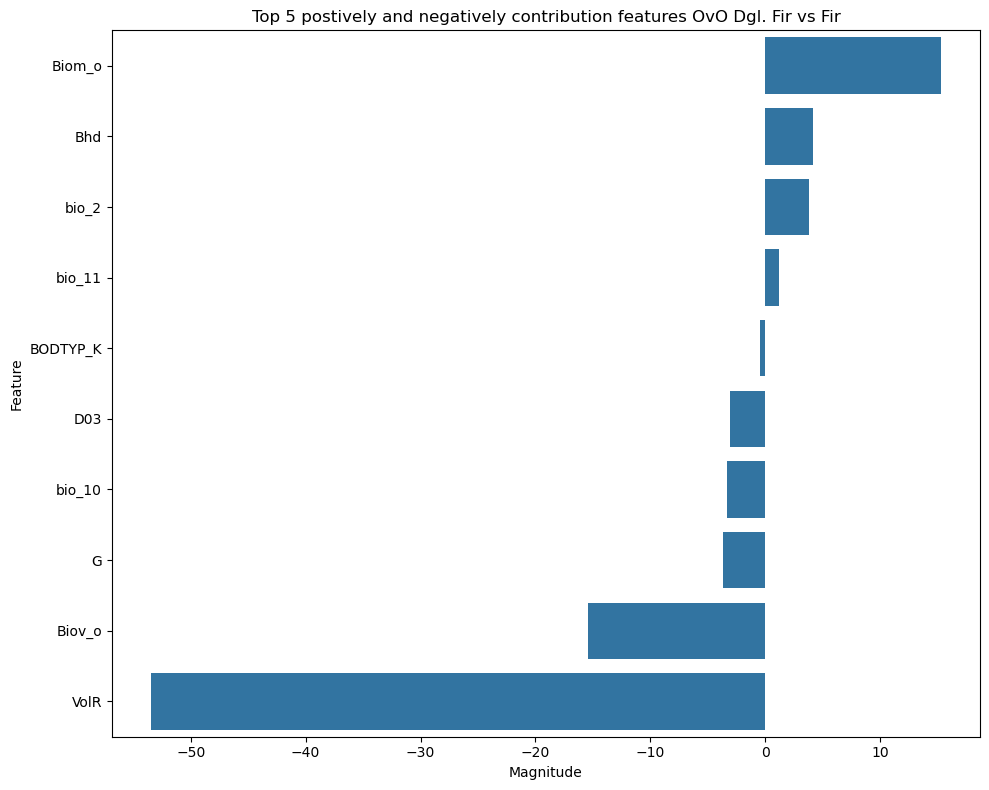

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(x='coef',
            y='feature',
            data=df_top_features.sort_values(by='coef', ascending=False)
)
plt.xlabel('Magnitude')
plt.ylabel('Feature')
plt.title('Top 5 postively and negatively contribution features OvO Dgl. Fir vs Fir')
plt.tight_layout()
plt.show()

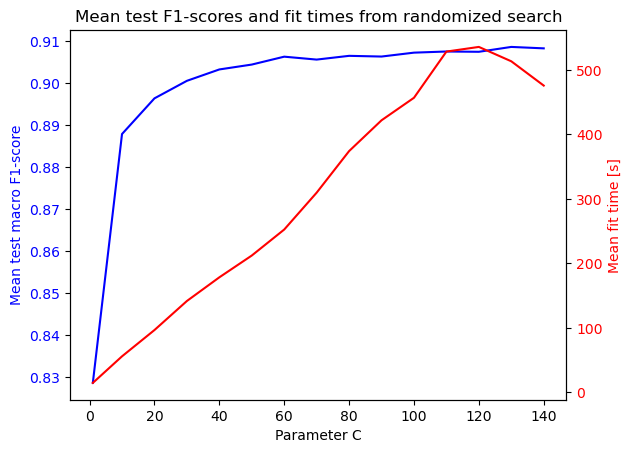

In [308]:
fig, ax1 = plt.subplots()

sns.lineplot(x='param_classifier__C', y='mean_test_f1_macro', data=gsearch_svc_u_linear_cv, ax=ax1, color='blue')
ax1.set_ylabel('Mean test macro F1-score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Parameter C')

ax2 = ax1.twinx()

sns.lineplot(x='param_classifier__C', y='mean_fit_time', data=gsearch_svc_u_linear_cv, ax=ax2, color='red')
ax2.set_ylabel('Mean fit time [s]', color='red')
ax2.tick_params(axis='y', labelcolor='red')


plt.title('Mean test F1-scores and fit times from randomized search')
plt.show()